In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 200
import warnings
warnings.filterwarnings('ignore')

# Problem Statement
Forecast the CocaCola prices data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting

In [2]:
df = pd.read_excel("E:\Data Science\Assignments\Forecasting\CocaCola_Sales_Rawdata.xlsx")

In [3]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


<Axes: >

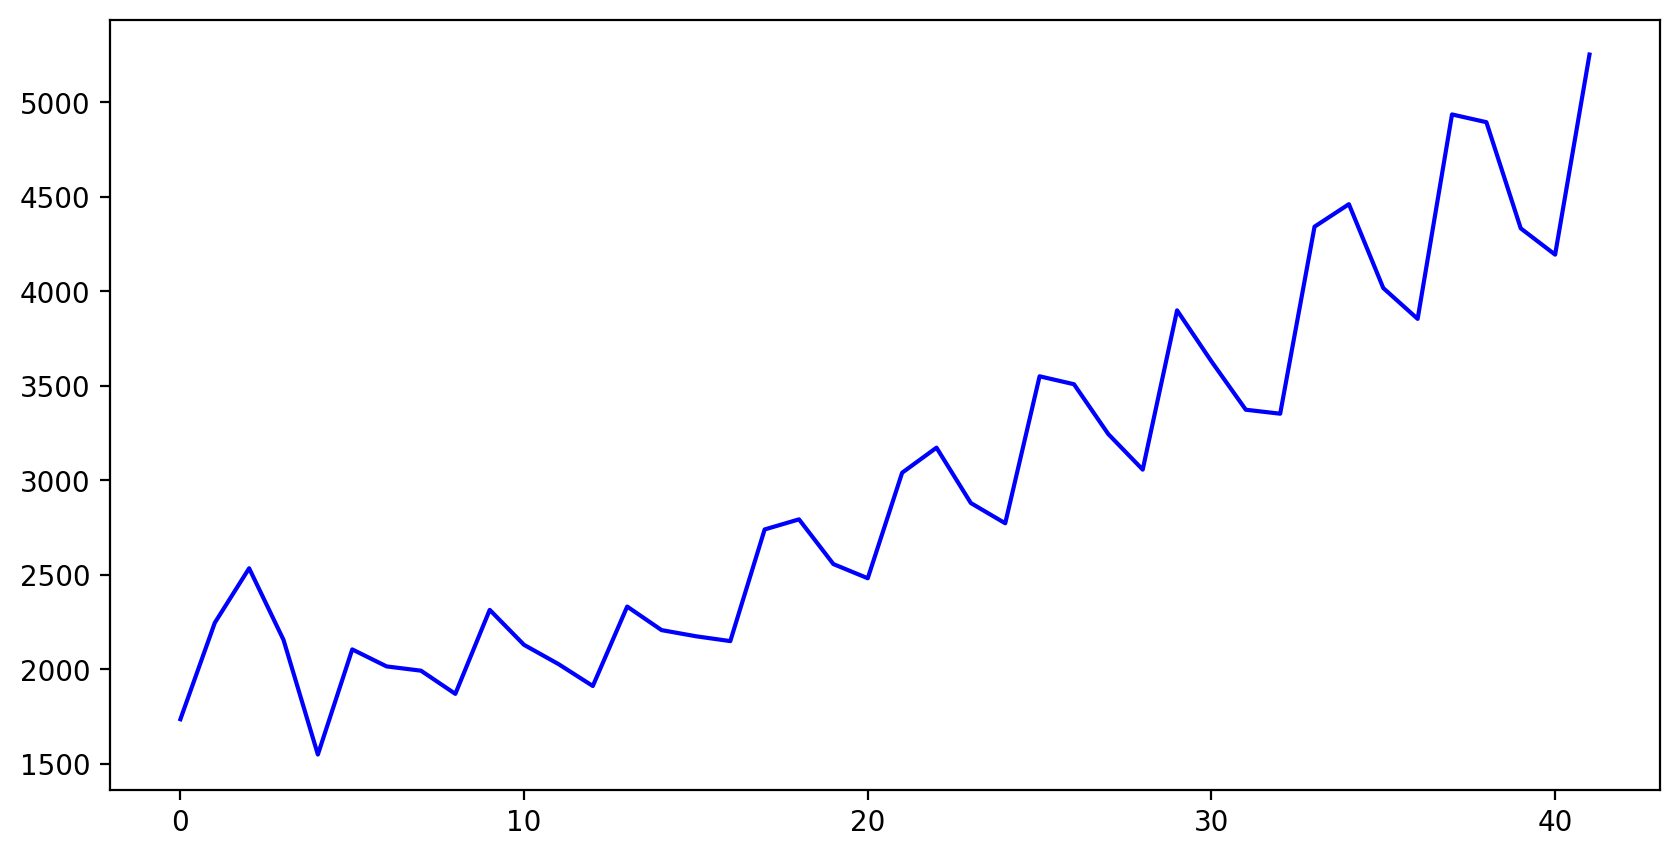

In [4]:
df.Sales.plot(color='blue')

<Axes: ylabel='Density'>

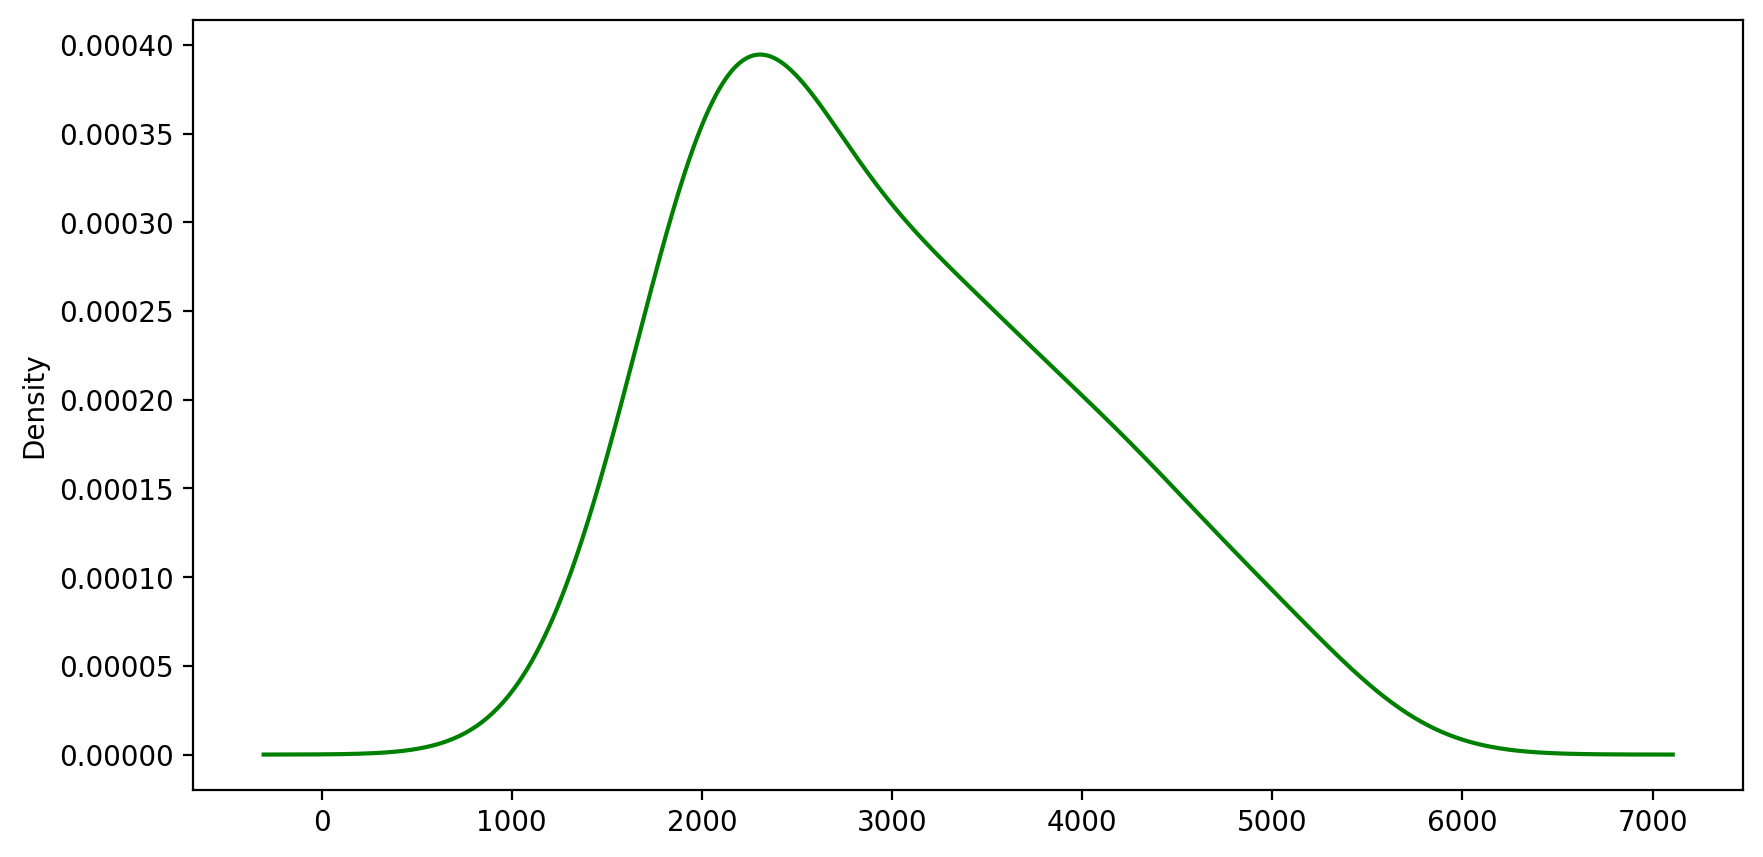

In [5]:
df.Sales.plot(kind='kde',color='green')

<Axes: ylabel='Frequency'>

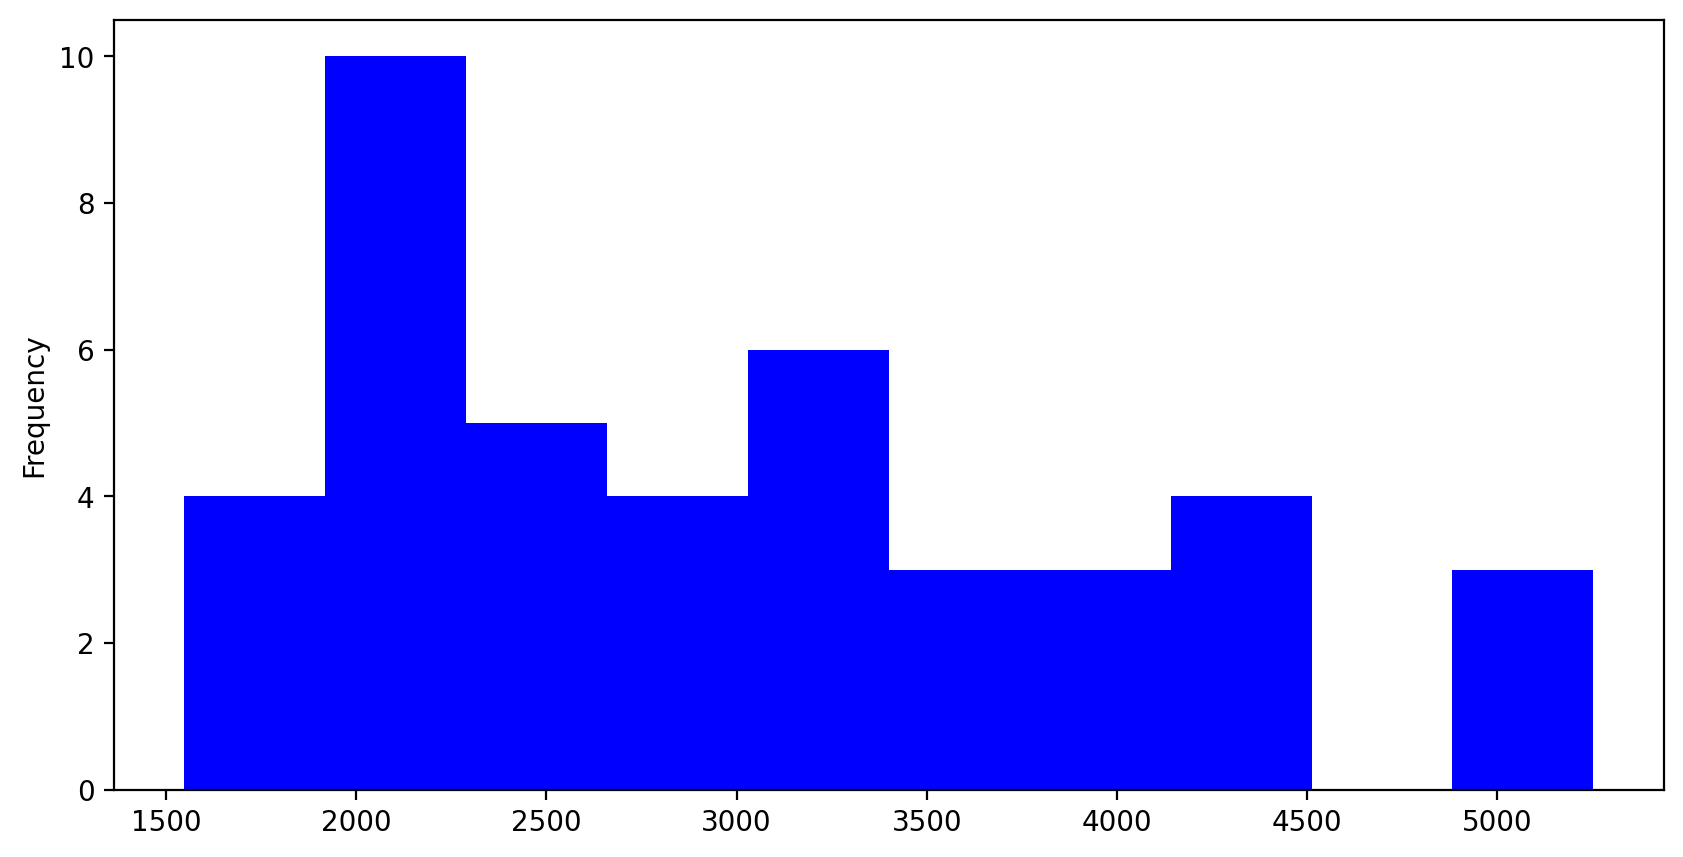

In [6]:
df.Sales.plot(kind='hist',color='blue')

In [7]:
temporary=pd.read_excel("E:\Data Science\Assignments\Forecasting\CocaCola_Sales_Rawdata.xlsx",header=0,index_col=0,parse_dates=True,squeeze=True)

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

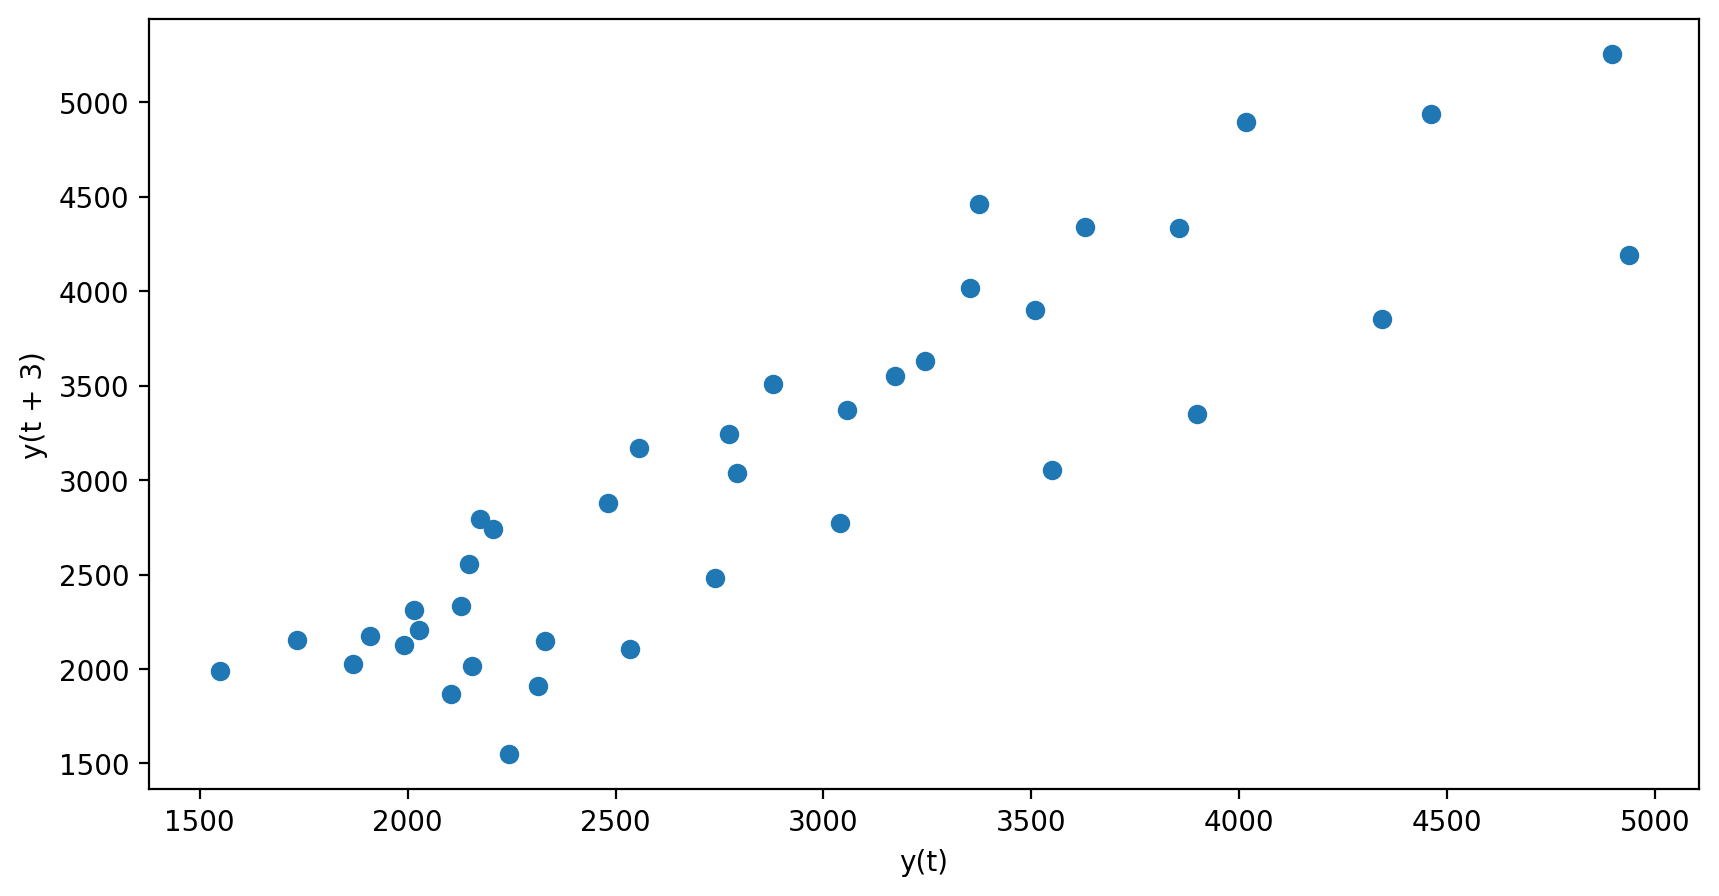

In [8]:
lag_plot(temporary,lag=3)

In [9]:
#one hot encoding.
df['Quarters']=0
df['Year']=0
for i in range(42):
    p=df['Quarter'][i]
    df['Quarters'][i]=p[0:2]
    df['Year'][i]=p[3:5]    

In [10]:
df.head(10)

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87
5,Q2_87,2104.411995,Q2,87
6,Q3_87,2014.362999,Q3,87
7,Q4_87,1991.746998,Q4,87
8,Q1_88,1869.049999,Q1,88
9,Q2_88,2313.631996,Q2,88


In [11]:
quarter_dumies=pd.DataFrame(pd.get_dummies(df['Quarters']))
quarter_dumies.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [12]:
# Concatinating the new dummy variables with the original dataset
df=pd.concat([df,quarter_dumies],axis=1)

In [13]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [14]:
# creating a column for time
df['time']=range(1,43)

In [15]:
# Creating a squared time column for using in the quardratic model
df['time_sqr']=df['time']*df['time']

In [16]:
# Creating a log transformation for the dependent variable for exponential model
df['log_sales']=np.log(df['Sales'])

<Axes: xlabel='Quarters', ylabel='Year'>

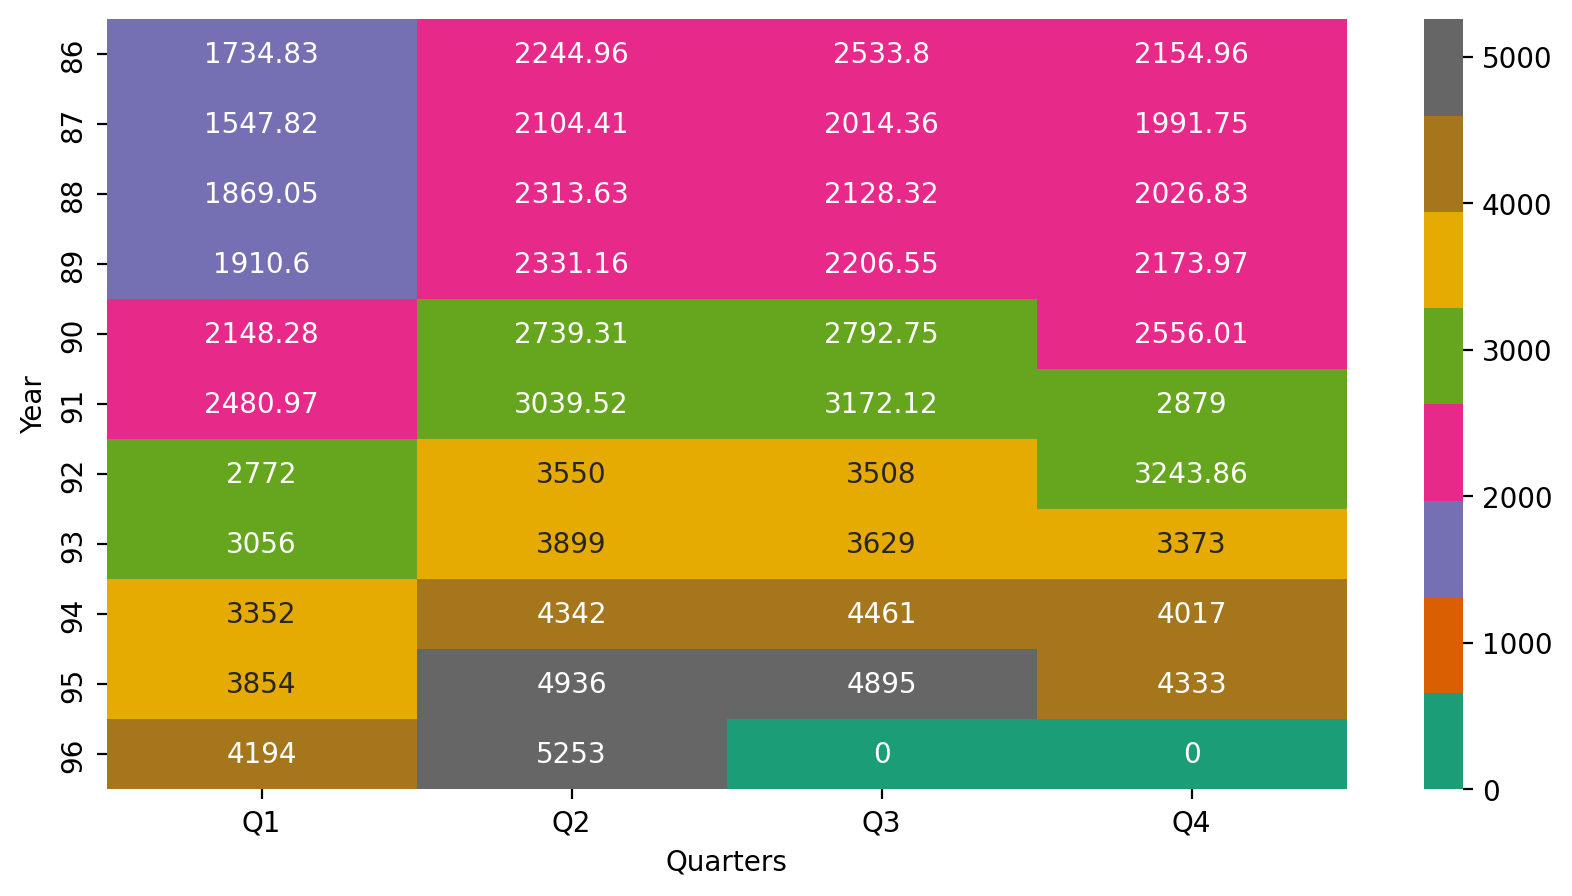

In [17]:
plot_month_y = pd.pivot_table(data = df,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g",cmap="Dark2")

<Axes: xlabel='Quarters', ylabel='Sales'>

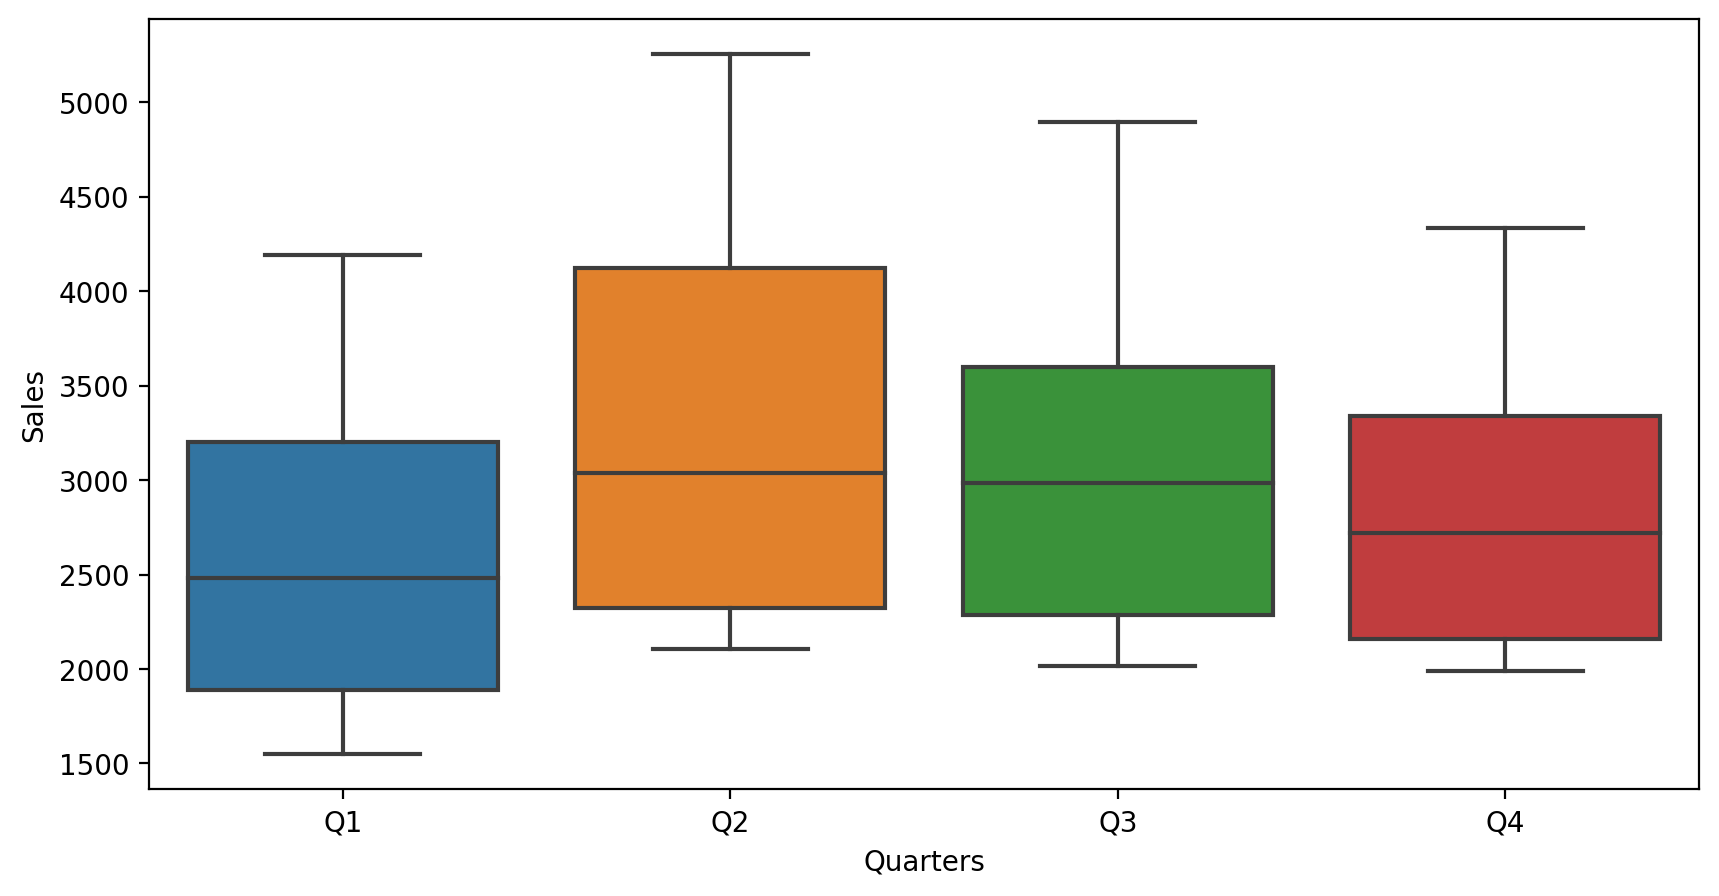

In [18]:
#  boxplot:To check   the sales of all the four quarters
sns.boxplot(x='Quarters',y='Sales',data=df)

<Axes: xlabel='Year', ylabel='Sales'>

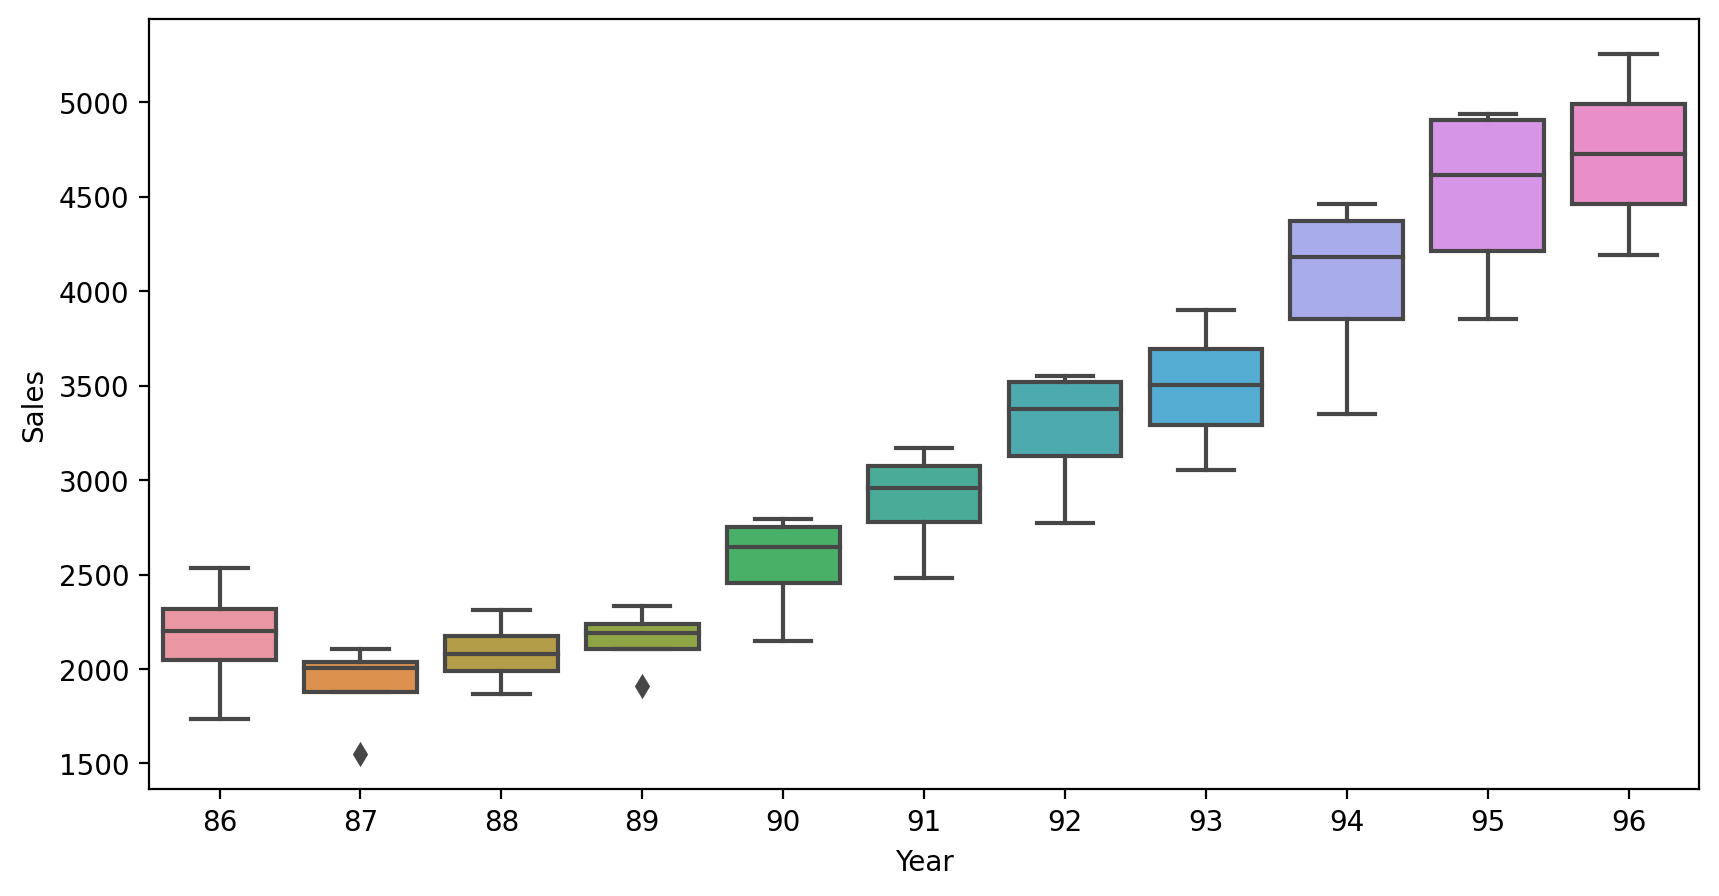

In [19]:
sns.boxplot(x='Year',y='Sales',data=df)

<Axes: xlabel='Year', ylabel='Sales'>

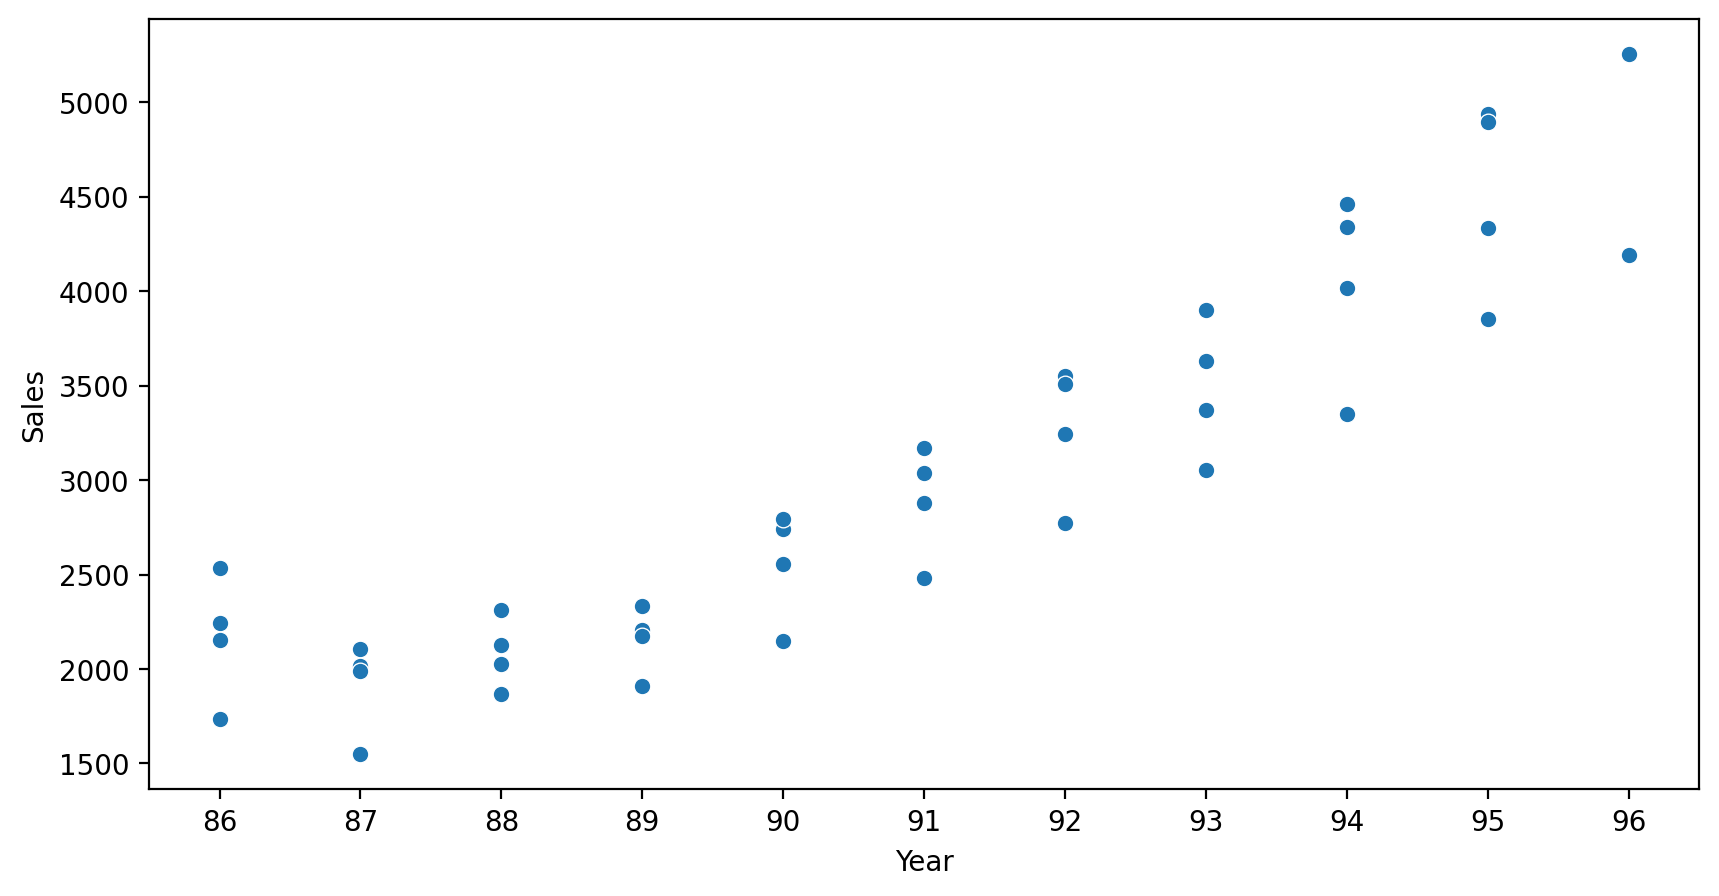

In [20]:
# scatter plot: To understand the past sales growth 
sns.scatterplot(x='Year',y='Sales',data = df)

##  Methods of forecasting

In [21]:
# SPLITTING THE DATASET INTO TRAIN AND TEST DATA 
train=df.head(30)
test=df.tail(12)

In [22]:
# LINEAR MODEL
linear_model = smf.ols('Sales~time',data=df).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['time'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

449.79962261229645

In [23]:
#EXPONENTIAL MODEL
Exp = smf.ols('log_sales~time',data=df).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['time'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

417.5608283749833

In [24]:
# QUARDRATIC MODEL
Quad = smf.ols('Sales~time+time_sqr',data=df).fit()
pred_Quad = pd.Series(Quad.predict(test[["time","time_sqr"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

394.75561592701087

In [25]:
#ADDITIVE SEASONALITY MODEL
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=df).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1305.6638874921075

In [26]:
#ADDITIVE SEASONALITY QUARDRATIC MODEL
add_sea_Quad = smf.ols('Sales~time+time_sqr+Q1+Q2+Q3+Q4',data=df).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['time','time_sqr','Q1','Q2','Q3','Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

170.42727210326223

In [27]:
#MULTIPLICATIVE SEASONALITY MODEL
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4',data = df).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1435.5011310008917

In [28]:
# MULTIPLICATIVE ADDITIVE SEASONALTY MODEL
Mul_Add_sea = smf.ols('log_sales~time+Q1+Q2+Q3+Q4',data =df).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

172.15056883930023

In [29]:
# Comparison between the all models within a table 
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,170.427272
6,rmse_Mult_add_sea,172.150569
2,rmse_Quad,394.755616
1,rmse_Exp,417.560828
0,rmse_linear,449.799623
3,rmse_add_sea,1305.663887
5,rmse_Mult_sea,1435.501131


### Prediction of Model

In [30]:
model_full = smf.ols('Sales~time+time_sqr+Q1+Q2+Q3+Q4',data = df).fit()
pred_full = pd.Series(model_full.predict(df))


In [31]:
df["Predicted_sales"]=pred_full

In [32]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,time,time_sqr,log_sales,Predicted_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663,1626.592727
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443,2268.402339
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477,2189.685821
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529,1867.242917
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602,1658.311143


## Inference:
We are getting the least RMSE value in additive seasonality quadratic model of 170.42, and that is why we built a model to predict using the same model on the whole data.